In [22]:
import sys
import itertools
import datetime, time
from datetime import timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fbprophet import Prophet
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
import boto3
%matplotlib inline

In [91]:
%load_ext autoreload
%autoreload 1
%aimport AWSArima
%aimport PredictAWSPrice
from AWSArima import ArimaPipeline
from PredictAWSPrice import PredictFuturePrice

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Extracting Instance Costs for 3 Months from AWS

The first thing that I did was get a list of all of the EC2 instances and combined those in a list.  

In [3]:
General_Instances = 'a1.medium , a1.large , a1.xlarge , a1.2xlarge , a1.4xlarge , m4.large , m4.xlarge , m4.2xlarge , m4.4xlarge , m4.10xlarge , m4.16xlarge , m5.large , m5.xlarge , m5.2xlarge , m5.4xlarge , m5.12xlarge , m5.24xlarge , m5.metal , m5a.large , m5a.xlarge , m5a.2xlarge , m5a.4xlarge , m5a.12xlarge , m5a.24xlarge , m5d.large , m5d.xlarge , m5d.2xlarge , m5d.4xlarge , m5d.12xlarge , m5d.24xlarge , m5d.metal , t2.nano , t2.micro , t2.small , t2.medium , t2.large , t2.xlarge , t2.2xlarge , t3.nano , t3.micro , t3.small , t3.medium , t3.large , t3.xlarge , t3.2xlarge'
Compute_Optimized ='c4.large , c4.xlarge , c4.2xlarge , c4.4xlarge , c4.8xlarge , c5.large , c5.xlarge , c5.2xlarge , c5.4xlarge , c5.9xlarge , c5.18xlarge , c5d.xlarge , c5d.2xlarge , c5d.4xlarge , c5d.9xlarge , c5d.18xlarge , c5n.large , c5n.xlarge , c5n.2xlarge , c5n.4xlarge , c5n.9xlarge , c5n.18xlarge'
Memory_Optimized = 'r4.large , r4.xlarge , r4.2xlarge , r4.4xlarge , r4.8xlarge , r4.16xlarge , r5.large , r5.xlarge , r5.2xlarge , r5.4xlarge , r5.12xlarge , r5.24xlarge , r5.metal , r5a.large , r5a.xlarge , r5a.2xlarge , r5a.4xlarge , r5a.12xlarge , r5a.24xlarge , r5d.large , r5d.xlarge , r5d.2xlarge , r5d.4xlarge , r5d.12xlarge , r5d.24xlarge , r5d.metal , u-6tb1.metal , u-9tb1.metal , u-12tb1.metal , x1.16xlarge , x1.32xlarge , x1e.xlarge , x1e.2xlarge , x1e.4xlarge , x1e.8xlarge , x1e.16xlarge , x1e.32xlarge , z1d.large , z1d.xlarge , z1d.2xlarge , z1d.3xlarge , z1d.6xlarge , z1d.12xlarge , z1d.metal'
Storage_Optimized = 'd2.xlarge , d2.2xlarge , d2.4xlarge , d2.8xlarge , h1.2xlarge , h1.4xlarge , h1.8xlarge , h1.16xlarge , i3.large , i3.xlarge , i3.2xlarge , i3.4xlarge , i3.8xlarge , i3.16xlarge , i3.metal'
Accelerated_Computing = 'f1.2xlarge , f1.4xlarge , f1.16xlarge , g3s.xlarge , g3.4xlarge , g3.8xlarge , g3.16xlarge , p2.xlarge , p2.8xlarge , p2.16xlarge , p3.2xlarge , p3.8xlarge , p3.16xlarge , p3dn.24xlarge'
                       

In [4]:
all_instances = General_Instances + Compute_Optimized + Memory_Optimized + Storage_Optimized + Accelerated_Computing

The instances are currently a string so the function below was written to make those instances a list.

In [5]:
def instance_to_list(instance_list):
    all_instances_list = []
    
    for word in instance_list.split():
        if word != ',':
            all_instances_list.append(word)   
    
    return all_instances_list

In [6]:
instance_types = instance_to_list(all_instances)

The AWS API allows for the retrieval of historical time series data for up to 3 months previous. 

In [7]:
number_of_days = 90
end = datetime.datetime.utcnow().strftime("%Y-%m-%dT%H:%M:%S")
start = (datetime.datetime.utcnow() - timedelta(days=number_of_days)).strftime("%Y-%m-%dT%H:%M:%S")

print("Will process from " + start + " to " + end)

Will process from 2019-01-03T19:59:01 to 2019-04-03T19:59:01


I created the predict future price class to serve as the end to end class to retrieve data, model the data, and make predictions on that data. The first thing that I did want is to retrieve the historical pricing data.

In [8]:
prices = PredictFuturePrice()

The AWS API needs the region specified so I will run the historical pricing method for all of the regions and pickle each file. I chose to do these one at a time because I am pulling pricing data for an entire region.

In [9]:
# region = 'us-east-1'
# region = 'us-east-2'
# region = 'us-west-1'
region = 'us-west-2'

In [10]:
df = prices.get_prices(start, end, instance_types, region)

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


In [11]:
df.head()

,AvailabilityZone,InstanceType,ProductDescription,SpotPrice,Timestamp
0,us-west-2c,g3s.xlarge,SUSE Linux,0.359100,2019-04-03 19:56:40+00:00
1,us-west-2c,g3s.xlarge,Linux/UNIX,0.259100,2019-04-03 19:56:40+00:00
2,us-west-2a,c5.2xlarge,SUSE Linux,0.232700,2019-04-03 19:56:25+00:00
3,us-west-2a,c5.2xlarge,Linux/UNIX,0.132700,2019-04-03 19:56:25+00:00
4,us-west-2c,t3.medium,Windows,0.028900,2019-04-03 19:56:23+00:00


The number of prices pulled for each region is as follows:

In [138]:
# us-east-1
len(df) 

306897

In [144]:
#us-east-2
len(df)

98472

In [149]:
#us-west-1
len(df)

84080

In [154]:
#us-west-2
len(df)

178957

Each region was saved as a pickle for later access.

In [155]:
df.to_pickle('us-west-2_12-9_18_to_3_9_18')

I then combined the data frames from each region into one data frame.

In [219]:
data = df.append(df1)
data = data.append(df2)
data = data.append(df3)
data = data.reset_index()

In [220]:
data.to_pickle('all_regions.pkl')

## Check to See if Price Changed

The price for an AWS instance only changes if there is demand for that instance so the price for many instances will not change over a 3 month period. I wanted to see how many regions had a price change over the last 3 months.

I used a mask for all unique permutations of the instance location, type, and operating description.  The first thing I did was get all unique combinations of Availability Zone, Instance Type, and Product Description.

In [12]:
availability_zone = list(df.AvailabilityZone.unique())
instance_type = list(df.InstanceType.unique())
product_description = list(df.ProductDescription.unique())

In [13]:
total_permutations = []
total_permutations.append(availability_zone)
total_permutations.append(instance_type)
total_permutations.append(product_description)

In [14]:
all_possibilities = list(itertools.product(*total_permutations))

In [237]:
# Look for change in price
price_changes = 0
previous_price = None
not_possibility = 0
not_combination = []
no_price_change = []
  
for possibility in all_possibilities:
    
    changes_in_price = 0
    mask = (df['AvailabilityZone'] == possibility[0]) & (df['InstanceType'] == possibility[1]) & (df['ProductDescription'] == possibility[2])
    price_series = df[mask]
    
    if len(price_series) == 0:
        not_possibility += 1
        not_combination.append(possibility)
        continue
    for ix, spot_price in enumerate(price_series['SpotPrice']):
        if previous_price is None:
            previous_price = spot_price
        if previous_price != spot_price:
            #price_changes +=1
            changes_in_price += 1
        #if the prices do not change at least 3 times then the series should be labelled as no change
        if changes_in_price > 2:
            price_changes +=1
            break
        previous_price = spot_price
        if ix == len(price_series['SpotPrice'])-1:
            no_price_change.append(possibility)
            
all_instance_type_permutations = [elem for elem in all_possibilities if elem not in not_combination]
instances_with_price_changes = [elem for elem in all_instance_type_permutations if elem not in no_price_change]
print(price_changes, price_changes/(len(all_possibilities)-not_possibility))

2294 0.5311414679323918


53% of the instances had prices changes over the 3 month historical pricing period. I went ahead and pickled all of the instance type permutations, all instances with price changes, and all instances without price changes. An ARIMA model throws an error if the model does not have a price change.

In [243]:
pd.Series(all_instance_type_permutations).to_pickle('all_instance_type_permutations.pkl')

In [244]:
pd.Series(instances_with_price_changes).to_pickle('instances_with_price_changes.pkl')

In [245]:
pd.Series(no_price_change).to_pickle('instances_without_price_changes.pkl')

I then took a look at a few instances with price changes to see what it looked like.  Below is one example.  The x axis is the 90 day period.

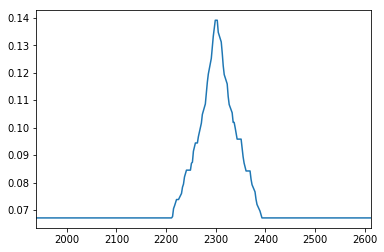

In [250]:
instance_ts = instances_with_price_changes[5]
mask = (df['AvailabilityZone'] == instance_ts[0]) & (df['InstanceType'] == instance_ts[1]) & (df['ProductDescription'] == instance_ts[2])
price_series = df[mask]
price_series['SpotPrice'].plot();

## Prophet

In [93]:
df2 = df1[availability_zone_mask].drop(['AvailabilityZone', 'InstanceType', 'ProductDescription'], axis = 1)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [94]:
df2.head()

,Timestamp,SpotPrice
603,2019-03-09 18:00:15+00:00,0.0168
609,2019-03-08 17:59:37+00:00,0.0168
615,2019-03-07 17:58:40+00:00,0.0168
621,2019-03-06 17:58:39+00:00,0.0168
627,2019-03-05 17:57:56+00:00,0.0168


In [95]:
df2 = df2.rename(index=str, columns={"Timestamp": "ds", "SpotPrice": "y"})

In [96]:
df2['ds'] = df2['ds'].apply(lambda x:datetime.datetime.replace(x,tzinfo=None))

In [97]:
model = Prophet()
model.fit(df2)

/anaconda3/lib/python3.6/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [98]:
# This adds 30 more rows to the dataframe which is already 100 rows
future = model.make_future_dataframe(periods=30)
future.shape

(178, 1)

In [99]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
173,2019-04-04 18:00:15,0.015181,0.013082,0.017234
174,2019-04-05 18:00:15,0.014612,0.012564,0.016609
175,2019-04-06 18:00:15,0.015357,0.013336,0.017536
176,2019-04-07 18:00:15,0.014475,0.012228,0.016556
177,2019-04-08 18:00:15,0.013837,0.011714,0.015991


/anaconda3/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


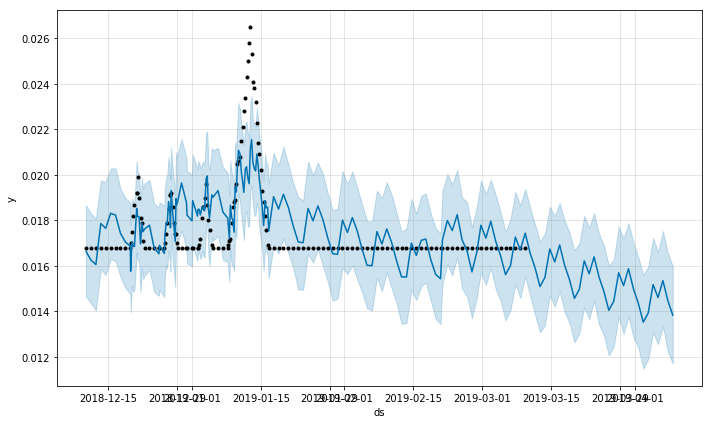

In [100]:
fig1 = model.plot(forecast)

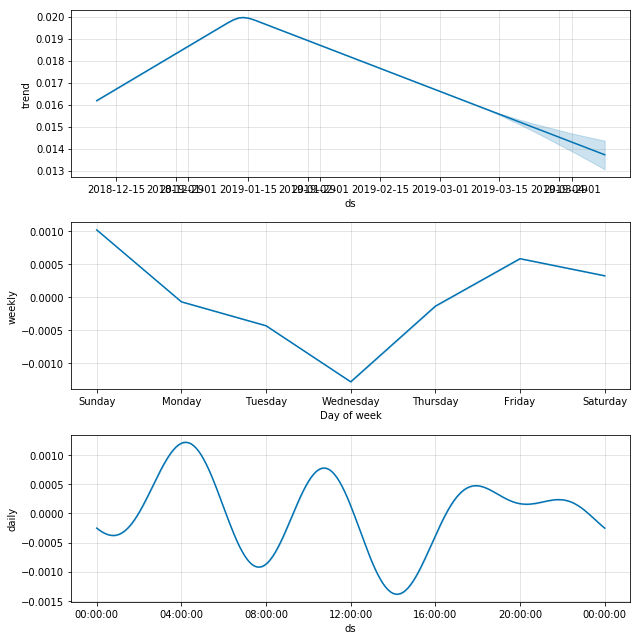

In [101]:
fig2 = model.plot_components(forecast)

## ARIMA 

In [92]:
arima = ArimaPipeline()

In [93]:
df = pd.read_pickle('all_regions.pkl')
instances_with_price_changes = pd.read_pickle('instances_with_price_changes.pkl')

In [94]:
arima.run_model(df, instances_with_price_changes, 788)

('us-east-1f', 'p3.8xlarge', 'Linux/UNIX')


0.03416198080582236

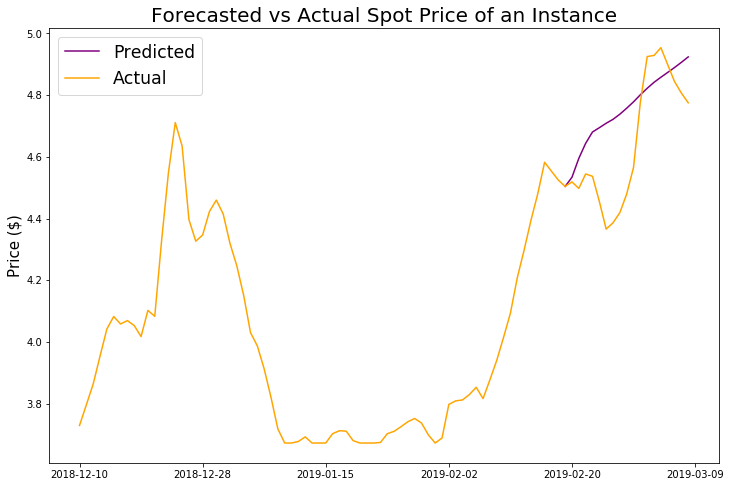

In [95]:
arima.plot_predictions()

In [96]:
arima.run_model(df, instances_with_price_changes, 217)

('us-east-1b', 'p3.16xlarge', 'SUSE Linux')


0.04627608693484533

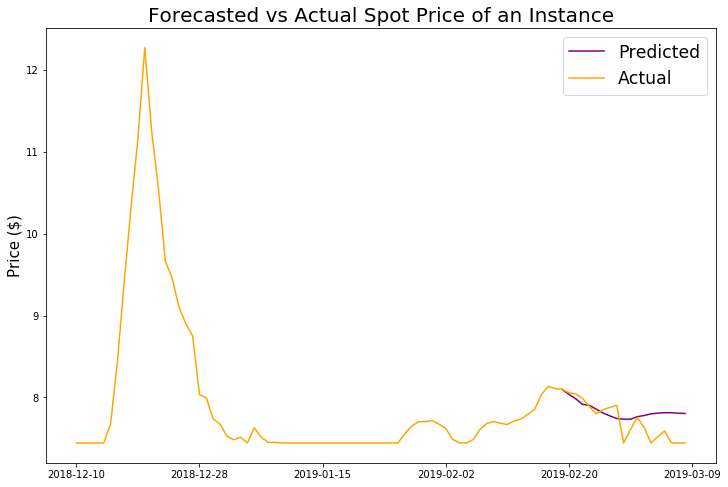

In [97]:
arima.plot_predictions()

In [70]:
arima.pipeline_iteration(df, instances_with_price_changes)

('us-east-1b', 'a1.large', 'SUSE Linux')
0 3.5691566787362986e-09
('us-east-1b', 'a1.large', 'Linux/UNIX')
1 3.545940337083809e-09
('us-east-1b', 'a1.xlarge', 'SUSE Linux')
2 3.0602049093564593e-15
('us-east-1b', 'a1.xlarge', 'Linux/UNIX')
3 1.4586956134011473e-17
('us-east-1b', 'a1.2xlarge', 'SUSE Linux')
4 2.2328861604721457e-15
('us-east-1b', 'a1.2xlarge', 'Linux/UNIX')
5 1.424977894527717e-15
('us-east-1b', 'a1.4xlarge', 'SUSE Linux')
6 4.172392777776224e-15
('us-east-1b', 'a1.4xlarge', 'Linux/UNIX')
7 2.0841482070781634e-15
('us-east-1b', 'm4.large', 'SUSE Linux')


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


8 2.1115809201863463e-13
('us-east-1b', 'm4.large', 'Linux/UNIX')
9 2.1111679671915164e-13
('us-east-1b', 'm4.xlarge', 'SUSE Linux')
10 4.586287661809957e-08
('us-east-1b', 'm4.xlarge', 'Linux/UNIX')
11 4.586307684866873e-08
('us-east-1b', 'm4.2xlarge', 'SUSE Linux')
12 6.638281079071578e-06
('us-east-1b', 'm4.2xlarge', 'Linux/UNIX')
13 6.6441869662260555e-06
('us-east-1b', 'm4.4xlarge', 'SUSE Linux')
14 0.00030890539157873737
('us-east-1b', 'm4.4xlarge', 'Linux/UNIX')
15 0.00030890350748193654
('us-east-1b', 'm4.10xlarge', 'SUSE Linux')


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:609: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()


16 Error
('us-east-1b', 'm4.10xlarge', 'Linux/UNIX')
17 2.040511231556327e-05
('us-east-1b', 'm4.16xlarge', 'SUSE Linux')


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:609: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()


18 Error
('us-east-1b', 'm4.16xlarge', 'Linux/UNIX')
19 Error
0.0006515953209072815


In [62]:
failed_list = []
for i in range(200):
    
    try:
        ts = apply_mask(df, instances, i)
        ds = downsample(ts)
        train, test = train_test_split(ds)
        tsmodel = create_a_model(train)
        print(i, calculate_error(tsmodel))
    except:
        print(i, "Error")
        failed_list.append(i)
        continue

0 6.246051137338585e-15
1 3.2334083645640432e-15
2 6.878812305037382e-15
3 5.0909337457881574e-15
4 8.29578938960043e-15
5 3.5180453984643145e-14
6 7.120198207964923e-15
7 1.0419440925927956e-14
8 1.700756028860316e-10
9 1.5718601865256368e-10
10 1.936356931117059e-08
11 1.936558399223881e-08
12 5.799865789379313e-06
13 5.799680532666958e-06
14 0.00011585393601806142
15 0.0001158530334363937


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:609: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()


16 Error
17 0.00012616673789721128


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:609: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()


18 Error
19 Error
20 8.638467086090322e-09
21 1.3349145632263292e-08
22 4.8694040198374474e-05
23 4.8681613849814604e-05
24 0.00023636833450401413
25 0.0002363683577240692
26 0.001191791430655667
27 0.0011917909907139628
28 7.26467739448387e-06
29 7.263854647741483e-06
30 Error


/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


31 Error
32 Error


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


33 6.486530475347573e-09
34 6.486530472106203e-09


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:609: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()


35 Error
36 5.814139447529514e-06
37 4.3763269050392474e-05
38 4.3762667337627485e-05
39 0.0003174906372697893
40 0.000317479599490016
41 5.550556061047347e-15
42 7.811460540907792e-15
43 Error
44 Error
45 Error
46 1.2483942846424503e-07


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:609: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()


47 Error
48 3.0561973991678496e-05
49 3.0566152632850015e-05


In [ ]:
kf = KalmanFilter()

In [320]:
len(failed_list)

68

In [222]:
df = pd.read_pickle('all_regions.pkl')
instance_ts = instances[10]
mask = (df['AvailabilityZone'] == instance_ts[0]) & (df['InstanceType'] == instance_ts[1]) & (df['ProductDescription'] == instance_ts[2])
price_series = df[mask]
prices = price_series[["SpotPrice"]]
prices = prices.set_index(pd.DatetimeIndex(price_series.Timestamp))
prices = prices.SpotPrice.resample('D').mean()

In [ ]:
size = int(len(prices) * 0.70)
train, test = prices[0:size], prices[size:len(prices)]

In [223]:
price_series.head()

,index,Timestamp,AvailabilityZone,InstanceType,ProductDescription,SpotPrice
5448,5448,2019-03-09 21:35:34+00:00,us-east-1b,m4.xlarge,SUSE Linux,0.1651
5458,5458,2019-03-08 22:57:38+00:00,us-east-1b,m4.xlarge,SUSE Linux,0.1652
5490,5490,2019-03-08 19:56:30+00:00,us-east-1b,m4.xlarge,SUSE Linux,0.1652
5512,5512,2019-03-07 19:56:25+00:00,us-east-1b,m4.xlarge,SUSE Linux,0.1652
5518,5518,2019-03-07 14:28:18+00:00,us-east-1b,m4.xlarge,SUSE Linux,0.1652


/anaconda3/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


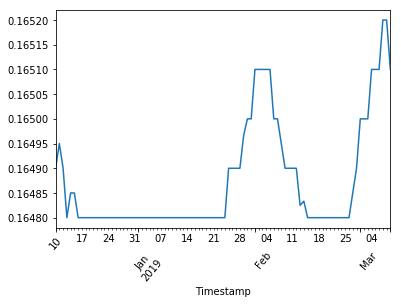

In [227]:
prices.plot()
plt.xticks(rotation=50);

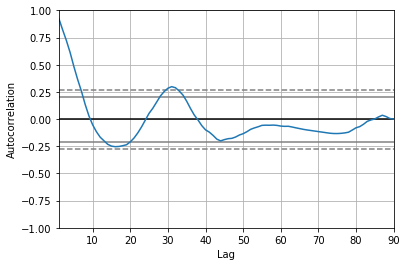

In [228]:
autocorrelation_plot(prices);

/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


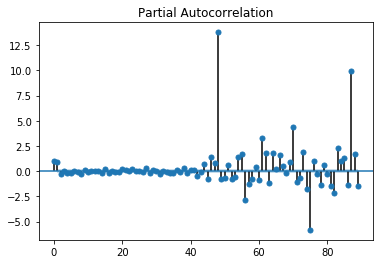

In [229]:
fig = sm.graphics.tsa.plot_pacf(prices)

## Create Model

In [56]:
model = ARIMA(train, order=(10,1,0))
model_fit = model.fit()

In [232]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.SpotPrice   No. Observations:                   61
Model:                ARIMA(10, 1, 0)   Log Likelihood                 556.390
Method:                       css-mle   S.D. of innovations              0.000
Date:                Thu, 14 Mar 2019   AIC                          -1088.779
Time:                        15:56:41   BIC                          -1063.449
Sample:                    12-11-2018   HQIC                         -1078.852
                         - 02-09-2019                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1.693e-07   3.83e-06      0.044      0.965   -7.35e-06    7.68e-06
ar.L1.D.SpotPrice     -0.0431      0.128     -0.336      0.738      -0.295       0.208
ar.L2.D.SpotPrice     -0.0041      0.129     -0.031      0.975      -0.257       0.249
ar.L3.D.SpotPrice      0.4223      0.137      3.081      0.003       0.154       0.691
ar.L4.D.SpotPrice      0.3694      0.168      2.201      0.032       0.040       0.698
ar.L5.D.SpotPrice     -0.2144      0.175     -1.227      0.226      -0.557       0.128
ar.L6.D.SpotPrice     -0.0563      0.173     -0.325      0.746      -0.396       0.283
ar.L7.D.SpotPrice     -0.0092      0.164     -0.056      0.956      -0.330       0.312
ar.L8.D.SpotPrice     -0.2390      0.155     -1.546      0.128      -0.542       0.064
ar.L9.D.SpotPrice      0.0356      0.179      0.199      0.843      -0.315       0.386
ar.L10.D.SpotPrice    -0.2399      0.179     -1.342      0.186      -0.590       0.111
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1             1.0129           -0.2892j            1.0534           -0.0443
AR.2             1.0129           +0.2892j            1.0534            0.0443
AR.3            -1.0450           -0.3384j            1.0985           -0.4502
AR.4            -1.0450           +0.3384j            1.0985            0.4502
AR.5             0.7264           -1.1085j            1.3253           -0.1577
AR.6             0.7264           +1.1085j            1.3253            0.1577
AR.7            -0.4521           -1.0181j            1.1140           -0.3165
AR.8            -0.4521           +1.0181j            1.1140            0.3165
AR.9            -0.1679           -1.1834j            1.1952           -0.2724
AR.10           -0.1679           +1.1834j            1.1952            0.2724
------------------------------------------------------------------------------
"""

/anaconda3/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


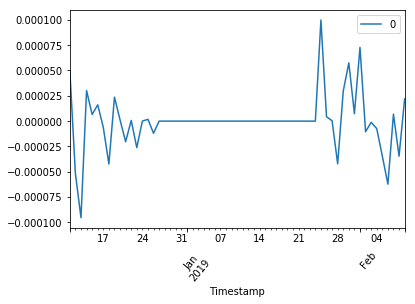

In [233]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.xticks(rotation=50);

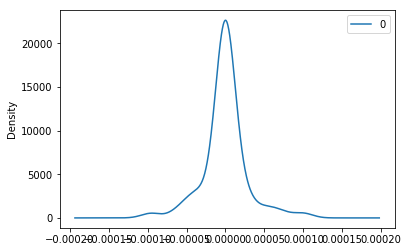

In [234]:
residuals.plot(kind='kde');

In [ ]:
forecasted_values = model_fit.forecast(len(test))
predictions = forecasted_values[0]
error = mean_squared_error(test, predictions)
error

In [235]:
forecasted_values = model_fit.forecast(len(test))

In [236]:
predictions = forecasted_values[0]

In [237]:
error = mean_squared_error(test, predictions)
error

2.1229118544869655e-08

#Build a function

In [201]:
size = int(len(prices) * 0.66)

In [60]:
train, test = prices[0:size], prices[size:len(prices)]

In [182]:
len(test)

47

In [61]:
history = [x for x in train]

In [62]:
predictions = list()

In [63]:
model = ARIMA(history, order=(5,1,0))

In [70]:
results = model.fit()

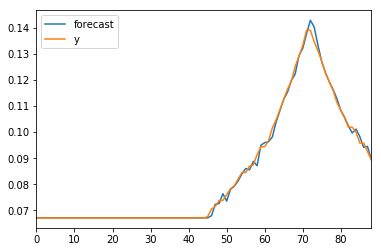

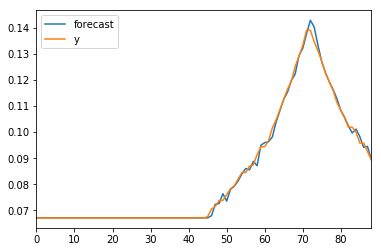

In [184]:
results.plot_predict()

In [183]:
results.forecast(47)

(array([0.08842506, 0.08616059, 0.0842862 , 0.08353384, 0.08221251,
        0.08125883, 0.08081035, 0.08011228, 0.07966312, 0.07943226,
        0.07909702, 0.0789113 , 0.07881725, 0.07868326, 0.07863354,
        0.07862155, 0.07859665, 0.07861736, 0.07865341, 0.07868692,
        0.07874441, 0.07880816, 0.07887272, 0.07894961, 0.07902913,
        0.07911012, 0.07919736, 0.07928575, 0.07937543, 0.07946823,
        0.07956158, 0.07965584, 0.07975164, 0.07984774, 0.07994442,
        0.08004187, 0.08013948, 0.08023744, 0.08033577, 0.08043421,
        0.08053285, 0.08063168, 0.08073056, 0.08082957, 0.08092866,
        0.08102779, 0.08112698]),
 array([0.00128879, 0.00243825, 0.00360943, 0.00512667, 0.00663723,
        0.00812155, 0.00967531, 0.01117783, 0.0126342 , 0.01407598,
        0.01546026, 0.01679611, 0.01809549, 0.01934389, 0.02054874,
        0.02171548, 0.02284009, 0.0239278 , 0.02498166, 0.0260014 ,
        0.02699054, 0.02795113, 0.02888407, 0.02979177, 0.03067574,
        0.0315

In [76]:
results.predict()

array([ 9.94173830e-05,  2.41383983e-05,  1.85350727e-05,  1.35439017e-05,
        1.76779635e-05,  1.73947367e-05,  1.73947367e-05,  1.73947367e-05,
        1.73947367e-05,  1.73947367e-05,  1.73947367e-05,  1.73947367e-05,
        1.73947367e-05,  1.73947367e-05,  1.73947367e-05,  1.73947367e-05,
        1.73947367e-05,  1.73947367e-05,  1.73947367e-05,  1.73947367e-05,
        1.73947367e-05,  1.73947367e-05,  1.73947367e-05,  1.73947367e-05,
        1.73947367e-05,  1.73947367e-05,  1.73947367e-05,  1.73947367e-05,
        1.73947367e-05,  1.73947367e-05,  1.73947367e-05,  1.73947367e-05,
        1.73947367e-05,  1.73947367e-05,  1.73947367e-05,  1.73947367e-05,
        1.73947367e-05,  1.73947367e-05,  1.73947367e-05,  1.73947367e-05,
        1.73947367e-05,  1.73947367e-05,  1.73947367e-05,  1.73947367e-05,
        1.73947367e-05,  1.73947367e-05,  3.20397172e-04,  1.82069750e-03,
        1.10260099e-03,  2.58122498e-03, -2.50520515e-04,  2.06222026e-03,
        9.04948085e-04,  

In [21]:
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

NameError: name 'test' is not defined

How to set up an AWS spot instance:
https://aws.amazon.com/blogs/compute/taking-advantage-of-amazon-ec2-spot-instance-interruption-notices/

In [115]:
for t in range(len(test)):
	model = ARIMA(history, order=(8,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

predicted=0.016800, expected=0.018600
predicted=0.019768, expected=0.018100
predicted=0.017877, expected=0.017200
predicted=0.017482, expected=0.016900
predicted=0.016531, expected=0.016800
predicted=0.016412, expected=0.016800
predicted=0.016491, expected=0.016800
predicted=0.016998, expected=0.016800
predicted=0.016774, expected=0.016800
predicted=0.016829, expected=0.016800
predicted=0.016852, expected=0.016800
predicted=0.016813, expected=0.016800
predicted=0.016806, expected=0.017000
predicted=0.017106, expected=0.017400
predicted=0.017598, expected=0.017400
predicted=0.017426, expected=0.017900
predicted=0.018264, expected=0.018600
predicted=0.018910, expected=0.019200
predicted=0.019582, expected=0.019100
predicted=0.019144, expected=0.019100
predicted=0.019239, expected=0.018500
predicted=0.018030, expected=0.017900
predicted=0.017550, expected=0.017400
predicted=0.016964, expected=0.017000
predicted=0.016684, expected=0.016800
predicted=0.016620, expected=0.016800
predicted=0.

ValueError: Found input variables with inconsistent numbers of samples: [51, 102]

In [281]:
model = ARIMA(prices, order=(5,1,0))
model_fit = model.fit()

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [283]:
pred_start = datetime.datetime.utcnow() + timedelta(days=1)
pred_end = datetime.datetime.utcnow() + timedelta(days=5)

In [286]:
pred_end

datetime.datetime(2019, 3, 18, 22, 55, 29, 927847)

## Create Future Price Prediction Pipeline

In [109]:
df1 = pd.read_pickle('instances_with_price_changes.pkl')

In [95]:
instance = ('us-east-1b', 'a1.large', 'SUSE Linux')

In [ ]:
df = pd.DataFrame()
for instance in df1:
    instance_test_pricing = PredictFuturePrice()
    df1 = instance_test_pricing.get_prices(start='3/18/2019 12:00 AM', end='3/23/2019 12:00 PM', instance=instance[1], instance_type=instance[2],availability_zone=instance[0])
    df = df.append(df1)

In [114]:
df.to_pickle('test_data.pkl')

In [68]:
instance_test_pricing = PredictFuturePrice()
instance_test_pricing.get_prices(start='3/18/2019 12:00 AM', end='3/23/2019 12:00 PM', instance=instance[1], instance_type=instance[2],availability_zone=instance[0])


,InstanceType,AvailabilityZone,ProductDescription,SpotPrice
2019-03-23 00:01:43+00:00,a1.large,us-east-1b,SUSE Linux,0.1168
2019-03-22 00:01:12+00:00,a1.large,us-east-1b,SUSE Linux,0.1168
2019-03-21 00:00:58+00:00,a1.large,us-east-1b,SUSE Linux,0.1168
2019-03-20 00:00:47+00:00,a1.large,us-east-1b,SUSE Linux,0.1168
2019-03-19 00:00:17+00:00,a1.large,us-east-1b,SUSE Linux,0.1168
2019-03-17 23:59:42+00:00,a1.large,us-east-1b,SUSE Linux,0.1168


In [12]:
#Create a test set
for instance in df1:
    instance_test_pricing = PredictFuturePrice()
    instance_test_pricing.get_prices(start='3/18/2019 12:00 AM', end='3/23/2019 12:00 PM', instance=instance[1], instance_type=instance[2],availability_zone=instance[0])
    

In [7]:
df = pd.read_pickle('all_regions.pkl')

In [8]:
df.head()

,index,Timestamp,AvailabilityZone,InstanceType,ProductDescription,SpotPrice
0,0,2019-03-09 07:57:59+00:00,us-east-1b,a1.medium,SUSE Linux,0.1084
1,1,2019-03-09 07:57:59+00:00,us-east-1a,a1.medium,SUSE Linux,0.1084
2,2,2019-03-09 07:57:59+00:00,us-east-1d,a1.medium,SUSE Linux,0.1084
3,3,2019-03-09 07:57:59+00:00,us-east-1b,a1.medium,Linux/UNIX,0.0084
4,4,2019-03-09 07:57:59+00:00,us-east-1a,a1.medium,Linux/UNIX,0.0084


In [30]:
start = '12/12/2018 10:03 AM'
end = '03/18/2019 10:04 AM'
instance = 'm4.xlarge'
instance_type = 'Linux/UNIX'
region = 'us-east-1'
availability_zone = 'B'
num_days = 10

In [34]:
test = PredictFuturePrice2()
test.multi_price(start,end,instance, instance_type, region)
test.multipipeline(10)
#test.get_similar_instances('Linux/UNIX', 'm4.xlarge') 

In [36]:
test.forecasted_values['us-east-1b']

array([0.0651729 , 0.06516464, 0.06514485, 0.06516787, 0.06520929,
       0.06520096, 0.06517639, 0.06519452, 0.06520992, 0.06520061])

In [ ]:
for key, value in test.prices.items():
    
    print(type(value))

In [ ]:
for i in range(len(test.prices)):
    
    test.prices

In [43]:
traces = []

In [68]:
test.forecast

AttributeError: 'PredictFuturePrice2' object has no attribute 'forecast'

In [70]:
list(test.forecasted_values['us-east-1b'])

[0.06517289704671717,
 0.06516463754378643,
 0.06514484705847873,
 0.06516787096578733,
 0.06520929447017189,
 0.06520096246325198,
 0.0651763875343549,
 0.06519452008688423,
 0.06520991812618568,
 0.06520060755991931]

In [21]:
(test.date_range + pd.DateOffset(5))[-5:]

DatetimeIndex(['2019-03-19 00:00:00+00:00', '2019-03-20 00:00:00+00:00',
               '2019-03-21 00:00:00+00:00', '2019-03-22 00:00:00+00:00',
               '2019-03-23 00:00:00+00:00'],
              dtype='datetime64[ns, tzutc()]', freq='D')

In [168]:
test.date_range.append(pd.date_range(pd.datetime.today(), periods=10))

Index([ 2018-12-21 00:00:00+00:00,  2018-12-22 00:00:00+00:00,
        2018-12-23 00:00:00+00:00,  2018-12-24 00:00:00+00:00,
        2018-12-25 00:00:00+00:00,  2018-12-26 00:00:00+00:00,
        2018-12-27 00:00:00+00:00,  2018-12-28 00:00:00+00:00,
        2018-12-29 00:00:00+00:00,  2018-12-30 00:00:00+00:00,
        2018-12-31 00:00:00+00:00,  2019-01-01 00:00:00+00:00,
        2019-01-02 00:00:00+00:00,  2019-01-03 00:00:00+00:00,
        2019-01-04 00:00:00+00:00,  2019-01-05 00:00:00+00:00,
        2019-01-06 00:00:00+00:00,  2019-01-07 00:00:00+00:00,
        2019-01-08 00:00:00+00:00,  2019-01-09 00:00:00+00:00,
        2019-01-10 00:00:00+00:00,  2019-01-11 00:00:00+00:00,
        2019-01-12 00:00:00+00:00,  2019-01-13 00:00:00+00:00,
        2019-01-14 00:00:00+00:00,  2019-01-15 00:00:00+00:00,
        2019-01-16 00:00:00+00:00,  2019-01-17 00:00:00+00:00,
        2019-01-18 00:00:00+00:00,  2019-01-19 00:00:00+00:00,
        2019-01-20 00:00:00+00:00,  2019-01-21 00:00:00

In [143]:
test.multipipeline(10)

/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [159]:
test.forecasted_values

{'us-east-1b': array([0.06517232, 0.06516377, 0.06514405, 0.06516733, 0.0652084 ,
        0.06519944, 0.06517526, 0.0651935 , 0.06520849, 0.06519859]),
 'us-east-1a': array([0.06601213, 0.06604293, 0.0660668 , 0.06607622, 0.06609855,
        0.06610229, 0.0661079 , 0.06611523, 0.06612058, 0.06613094]),
 'us-east-1d': array([0.06496301, 0.06497236, 0.0649952 , 0.06494909, 0.06495168,
        0.0649762 , 0.06496588, 0.06495227, 0.06494383, 0.06498348]),
 'us-east-1f': array([0.0648, 0.0648, 0.0648, 0.0648, 0.0648, 0.0648, 0.0648, 0.0648,
        0.0648, 0.0648]),
 'us-east-1c': array([0.0725588 , 0.07268057, 0.07293401, 0.07312679, 0.07302575,
        0.07272152, 0.0724372 , 0.07228995, 0.0723849 , 0.07261479]),
 'us-east-1e': array([0.0648, 0.0648, 0.0648, 0.0648, 0.0648, 0.0648, 0.0648, 0.0648,
        0.0648, 0.0648]),
 'us-east-2b': array([0.03895165, 0.03897661, 0.03895137, 0.03894945, 0.03895402,
        0.03895702, 0.03897339, 0.03897484, 0.03898606, 0.03900236]),
 'us-east-2a': a

In [158]:
fdatelist = pd.date_range(pd.datetime.today(), periods=3)

In [156]:
fdatelist

DatetimeIndex(['2019-03-20 15:46:08.957997', '2019-03-21 15:46:08.957997',
               '2019-03-22 15:46:08.957997'],
              dtype='datetime64[ns]', freq='D')

In [144]:
test.forecasted_values

{'us-east-1b': array([0.06517232, 0.06516377, 0.06514405, 0.06516733, 0.0652084 ,
        0.06519944, 0.06517526, 0.0651935 , 0.06520849, 0.06519859]),
 'us-east-1a': array([0.06601213, 0.06604293, 0.0660668 , 0.06607622, 0.06609855,
        0.06610229, 0.0661079 , 0.06611523, 0.06612058, 0.06613094]),
 'us-east-1d': array([0.06496301, 0.06497236, 0.0649952 , 0.06494909, 0.06495168,
        0.0649762 , 0.06496588, 0.06495227, 0.06494383, 0.06498348]),
 'us-east-1f': array([0.0648, 0.0648, 0.0648, 0.0648, 0.0648, 0.0648, 0.0648, 0.0648,
        0.0648, 0.0648]),
 'us-east-1c': array([0.0725588 , 0.07268057, 0.07293401, 0.07312679, 0.07302575,
        0.07272152, 0.0724372 , 0.07228995, 0.0723849 , 0.07261479]),
 'us-east-1e': array([0.0648, 0.0648, 0.0648, 0.0648, 0.0648, 0.0648, 0.0648, 0.0648,
        0.0648, 0.0648]),
 'us-east-2b': array([0.03895165, 0.03897661, 0.03895137, 0.03894945, 0.03895402,
        0.03895702, 0.03897339, 0.03897484, 0.03898606, 0.03900236]),
 'us-east-2a': a

In [86]:
for price_set in test.prices:
    print(price_set)

us-east-1b
us-east-1a
us-east-1d
us-east-1f
us-east-1c
us-east-1e
us-east-2b
us-east-2a
us-east-2c
us-west-1b
us-west-1c
us-west-2c
us-west-2a
us-west-2b


In [19]:
ec2_pricing = PredictFuturePrice()
ec2_pricing.get_similar_instances('Linux/UNIX', 'm4.xlarge') 
#ec2_pricing.pipeline(start, end, instance, instance_type, region, availability_zone, num_days)

In [30]:
ec2_pricing.configs_to_run

[('us-east-1b', 'm4.xlarge', 'Linux/UNIX'),
 ('us-east-1a', 'm4.xlarge', 'Linux/UNIX'),
 ('us-east-1d', 'm4.xlarge', 'Linux/UNIX'),
 ('us-east-1f', 'm4.xlarge', 'Linux/UNIX'),
 ('us-east-1c', 'm4.xlarge', 'Linux/UNIX'),
 ('us-east-1e', 'm4.xlarge', 'Linux/UNIX'),
 ('us-east-2b', 'm4.xlarge', 'Linux/UNIX'),
 ('us-east-2a', 'm4.xlarge', 'Linux/UNIX'),
 ('us-east-2c', 'm4.xlarge', 'Linux/UNIX'),
 ('us-west-1b', 'm4.xlarge', 'Linux/UNIX'),
 ('us-west-1c', 'm4.xlarge', 'Linux/UNIX'),
 ('us-west-2c', 'm4.xlarge', 'Linux/UNIX'),
 ('us-west-2a', 'm4.xlarge', 'Linux/UNIX'),
 ('us-west-2b', 'm4.xlarge', 'Linux/UNIX')]

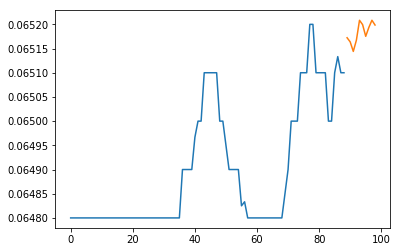

In [13]:
ec2_pricing.plot()

In [251]:
df_regions = pd.read_pickle('all_regions.pkl')

In [253]:
df_regions.ProductDescription.unique()

array(['SUSE Linux', 'Linux/UNIX', 'Windows'], dtype=object)

In [206]:
df_regions.AvailabilityZone.unique()

array(['us-east-1b', 'us-east-1a', 'us-east-1d', 'us-east-1f',
       'us-east-1c', 'us-east-1e', 'us-east-2b', 'us-east-2a',
       'us-east-2c', 'us-west-1b', 'us-west-1c', 'us-west-2c',
       'us-west-2a', 'us-west-2b', 'us-west-2d'], dtype=object)

In [3]:
configurations = pd.read_pickle('all_instance_type_permutations.pkl')

## Check for all Availability Zones

In [2]:
start = '12/12/2018 10:03 AM'
end = '03/18/2019 10:04 AM'
instance = 'm4.xlarge'
instance_type = 'Linux/UNIX (Amazon VPC)'
region = 'us-east-1'
availability_zone = 'B'
num_days = 10

In [4]:
selected_regions = ['us-east-1', 'us-east-2', 'us-west-1', 'us-west-2']

In [6]:
regions = ['us-east-1b', 'us-east-1a', 'us-east-1d', 'us-east-1f',
       'us-east-1c', 'us-east-1e', 'us-east-2b', 'us-east-2a',
       'us-east-2c', 'us-west-1b', 'us-west-1c', 'us-west-2c',
       'us-west-2a', 'us-west-2b', 'us-west-2d']

In [7]:
availability_zone_list = []
selected_region = selected_regions[0]

for availability_zone in regions:
    if selected_region in availability_zone: 
        availability_zone_list.append(availability_zone)
availability_zone_list

['us-east-1b',
 'us-east-1a',
 'us-east-1d',
 'us-east-1f',
 'us-east-1c',
 'us-east-1e']

In [ ]:
os_types = ['SUSE Linux', 'Linux/UNIX', 'Windows']

In [9]:
os_type = 'Linux/UNIX'

In [12]:
instance_type = 'm4.large'

In [14]:
configs_to_run = []
for config in configurations:
    if os_type in config and instance_type in config:
        configs_to_run.append(config)
configs_to_run

[('us-east-1b', 'm4.large', 'Linux/UNIX'),
 ('us-east-1a', 'm4.large', 'Linux/UNIX'),
 ('us-east-1d', 'm4.large', 'Linux/UNIX'),
 ('us-east-1f', 'm4.large', 'Linux/UNIX'),
 ('us-east-1c', 'm4.large', 'Linux/UNIX'),
 ('us-east-1e', 'm4.large', 'Linux/UNIX'),
 ('us-east-2b', 'm4.large', 'Linux/UNIX'),
 ('us-east-2a', 'm4.large', 'Linux/UNIX'),
 ('us-east-2c', 'm4.large', 'Linux/UNIX'),
 ('us-west-1b', 'm4.large', 'Linux/UNIX'),
 ('us-west-1c', 'm4.large', 'Linux/UNIX'),
 ('us-west-2c', 'm4.large', 'Linux/UNIX'),
 ('us-west-2a', 'm4.large', 'Linux/UNIX'),
 ('us-west-2b', 'm4.large', 'Linux/UNIX')]